In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from matplotlib.pylab import rcParams

plt.style.use('ggplot')
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)

# Functions

In [84]:
def get_datetimes(df, n):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[n:], format='%Y-%m')

In [85]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionID', 'SizeRank', 'Zipcode', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

# Importing Data

From the zillow website, we imported the home value data.

In [86]:
df = pd.read_csv('zillow_data.csv')
df.head()

RegionID  SizeRank  RegionName RegionType StateName State      City  \
0     61639         0       10025        Zip        NY    NY  New York   
1     84654         1       60657        Zip        IL    IL   Chicago   
2     61637         2       10023        Zip        NY    NY  New York   
3     91982         3       77494        Zip        TX    TX      Katy   
4     84616         4       60614        Zip        IL    IL   Chicago   

                              Metro       CountyName  2000-01-31  2000-02-29  \
0       New York-Newark-Jersey City  New York County    329121.0    334059.0   
1          Chicago-Naperville-Elgin      Cook County    311929.0    313378.0   
2       New York-Newark-Jersey City  New York County    500887.0    504739.0   
3  Houston-The Woodlands-Sugar Land    Harris County    225325.0    225644.0   
4          Chicago-Naperville-Elgin      Cook County    405926.0    407067.0   

   2000-03-31  2000-04-30  2000-05-31  2000-06-30  2000-07-31  2000-08-31  \
0    338019.0    346657.0    354457.0    361917.0    369769.0    376112.0   
1    315344.0    319125.0    322989.0    326767.0    330668.0    335062.0   
2    507445.0    514136.0    522082.0    532837.0    543268.0    551851.0   
3    226370.0    227601.0    227163.0    226825.0    225702.0    226045.0   
4    409223.0    412990.0    417544.0    421908.0    426505.0    431388.0   

   2000-09-30  2000-10-31  2000-11-30  2000-12-31  2001-01-31  2001-02-28  \
0    381673.0    386586.0    394154.0    402687.0    412006.0    420541.0   
1    338888.0    342690.0    346612.0    350927.0    355088.0    358408.0   
2    557627.0    564580.0    572819.0    582608.0    592058.0    602852.0   
3    225646.0    226321.0    227497.0    228927.0    229550.0    228851.0   
4    435548.0    440519.0    445834.0    451565.0    456517.0    460220.0   

   2001-03-31  2001-04-30  2001-05-31  2001-06-30  2001-07-31  2001-08-31  \
0    429242.0    436291.0    442139.0    447655.0    452725.0    457455.0   
1    362212.0    365119.0    368069.0    370481.0    372879.0    375542.0   
2    614142.0    622930.0    629825.0    636113.0    643638.0    648479.0   
3    227979.0    227122.0    228447.0    229973.0    231156.0    231468.0   
4    464884.0    469148.0    473014.0    476045.0    478475.0    481853.0   

   2001-09-30  2001-10-31  2001-11-30  2001-12-31  2002-01-31  2002-02-28  \
0    461020.0    465658.0    469811.0    475268.0    478912.0    482464.0   
1    378529.0    382631.0    386238.0    388784.0    390976.0    393352.0   
2    653604.0    658752.0    666537.0    673080.0    680428.0    687038.0   
3    231033.0    231096.0    230626.0    229665.0    229077.0    228759.0   
4    485145.0    488895.0    492075.0    494688.0    497482.0    500398.0   

   2002-03-31  2002-04-30  2002-05-31  2002-06-30  2002-07-31  2002-08-31  \
0    484481.0    488259.0    493127.0    499165.0    503717.0    507932.0   
1    396645.0    398463.0    400061.0    400541.0    401841.0    403663.0   
2    693996.0    700773.0    708029.0    715294.0    721571.0    726948.0   
3    229655.0    230329.0    231441.0    232195.0    232058.0    231451.0   
4    504079.0    505996.0    507710.0    508146.0    510190.0    512603.0   

   2002-09-30  2002-10-31  2002-11-30  2002-12-31  2003-01-31  2003-02-28  \
0    511068.0    514280.0    518252.0    522487.0    527352.0    531284.0   
1    405854.0    407831.0    409137.0    411372.0    414238.0    417630.0   
2    732355.0    737929.0    743767.0    749049.0    755232.0    761336.0   
3    230066.0    229499.0    228693.0    229568.0    230926.0    232501.0   
4    515669.0    518306.0    520661.0    523906.0    527538.0    531203.0   

   2003-03-31  2003-04-30  2003-05-31  2003-06-30  2003-07-31  2003-08-31  \
0    535317.0    539349.0    549450.0    567133.0    588505.0    605851.0   
1    420207.0    422294.0    422278.0    421952.0    421369.0    421774.0   
2    767639.0    773561.0    784567.0    805904.0    822204.0    835

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30523 entries, 0 to 30522
Columns: 269 entries, RegionID to 2021-08-31
dtypes: float64(260), int64(3), object(6)
memory usage: 62.6+ MB


The dataset has 30,523 rows and 269 columns.

# Data EDA/Cleaning

## Visualiztion

Maximum median : 682497.1739130435
Maximum mean : 190265.94346289753


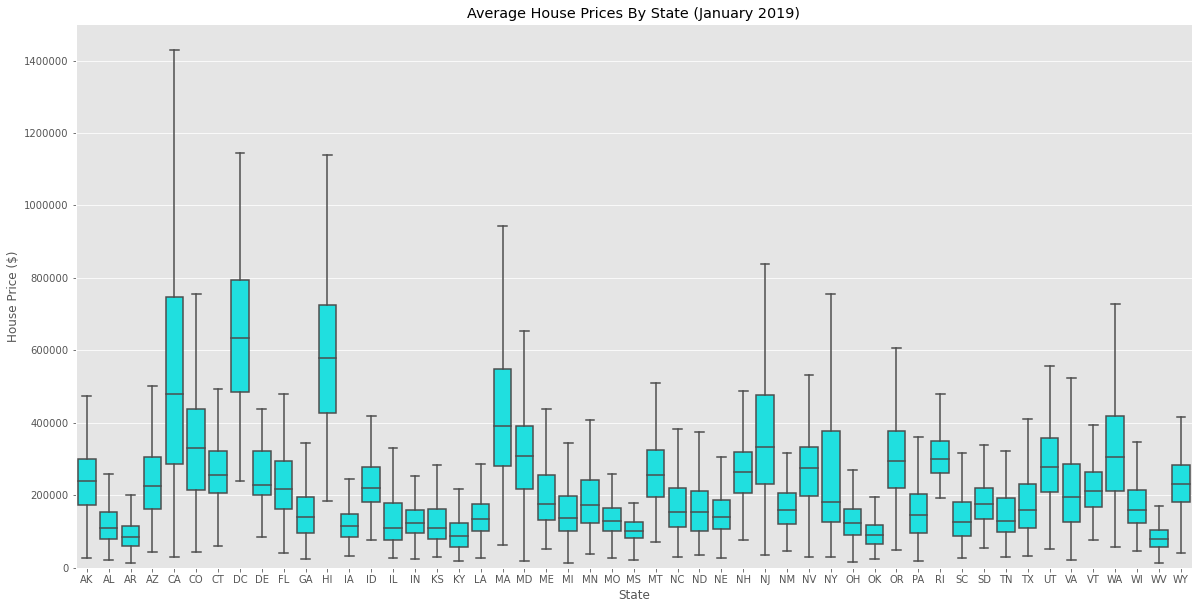

In [89]:
import seaborn as sns

plt.figure(figsize=(20,10))

# Put states in descending order based on their medians:
state_order = sorted(list(set(df['State'])))

# Create a boxplot for each state:
sns.boxplot(x='State',y='2019-01-31',
            data=df,order=state_order,
            showfliers=False, color = 'Aqua')

# Set labels and axis limits:
plt.ylim(0,);
plt.xlabel('State')
plt.ylabel('House Price ($)')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Average House Prices By State (January 2019)');

# Print maximum mean and median value
print('Maximum median',':',df.groupby('State').mean()['2019-01-31'].max())
print('Maximum mean',':',df.groupby('State').mean()['2019-01-31'].median())

First, we changed RegionName feature name to Zipcode for easier read.

In [90]:
df = df.rename(columns={'RegionName': 'Zipcode'})

Since our stakeholder is looking for north-eastern area, we are going to take data from only NY, NJ, PA, MA, and CT states.

In [91]:
df = df[df['State'].isin(['NY', 'NJ', 'PA', 'MA', 'CT'])]
df.head()

RegionID  SizeRank  Zipcode RegionType StateName State      City  \
0      61639         0    10025        Zip        NY    NY  New York   
2      61637         2    10023        Zip        NY    NY  New York   
6      61616         6    10002        Zip        NY    NY  New York   
10     62037        10    11226        Zip        NY    NY  New York   
11     61807        11    10467        Zip        NY    NY  New York   

                          Metro       CountyName  2000-01-31  2000-02-29  \
0   New York-Newark-Jersey City  New York County    329121.0    334059.0   
2   New York-Newark-Jersey City  New York County    500887.0    504739.0   
6   New York-Newark-Jersey City  New York County    437758.0    432015.0   
10  New York-Newark-Jersey City     Kings County    264706.0    266665.0   
11  New York-Newark-Jersey City     Bronx County    155345.0    156677.0   

    2000-03-31  2000-04-30  2000-05-31  2000-06-30  2000-07-31  2000-08-31  \
0     338019.0    346657.0    354457.0    361917.0    369769.0    376112.0   
2     507445.0    514136.0    522082.0    532837.0    543268.0    551851.0   
6     432238.0    430229.0    435590.0    438695.0    443482.0    444291.0   
10    267998.0    270531.0    273022.0    275674.0    278628.0    280220.0   
11    157749.0    160267.0    162638.0    165060.0    166528.0    167809.0   

    2000-09-30  2000-10-31  2000-11-30  2000-12-31  2001-01-31  2001-02-28  \
0     381673.0    386586.0    394154.0    402687.0    412006.0    420541.0   
2     557627.0    564580.0    572819.0    582608.0    592058.0    602852.0   
6     443860.0    442945.0    441965.0    444749.0    450320.0    462165.0   
10    281667.0    282521.0    283991.0    286051.0    289279.0    292536.0   
11    169200.0    170578.0    172401.0    173632.0    175347.0    175628.0   

    2001-03-31  2001-04-30  2001-05-31  2001-06-30  2001-07-31  2001-08-31  \
0     429242.0    436291.0    442139.0    447655.0    452725.0    457455.0   
2     614142.0    622930.0    629825.0    636113.0    643638.0    648479.0   
6     474048.0    487589.0    496509.0    504623.0    505852.0    508437.0   
10    295986.0    299032.0    302770.0    306193.0    309885.0    312641.0   
11    176474.0    177199.0    178880.0    180258.0    181764.0    182942.0   

    2001-09-30  2001-10-31  2001-11-30  2001-12-31  2002-01-31  2002-02-28  \
0     461020.0    465658.0    469811.0    475268.0    478912.0    482464.0   
2     653604.0    658752.0    666537.0    673080.0    680428.0    687038.0   
6     510179.0    514685.0    525158.0    537677.0    552052.0    560318.0   
10    315545.0    318901.0    321346.0    322380.0    322857.0    326182.0   
11    183942.0    184296.0    184646.0    186106.0    187989.0    190296.0   

    2002-03-31  2002-04-30  2002-05-31  2002-06-30  2002-07-31  2002-08-31  \
0     484481.0    488259.0    493127.0    499165.0    503717.0    507932.0   
2     693996.0    700773.0    708029.0    715294.0    721571.0    726948.0   
6     567921.0    574662.0    579806.0    585728.0    590181.0    596179.0   
10    319223.0    311807.0    302413.0    303673.0    304631.0    311444.0   
11    191790.0    193453.0    195234.0    197080.0    198995.0    200771.0   

    2002-09-30  2002-10-31  2002-11-30  2002-12-31  2003-01-31  2003-02-28  \
0     511068.0    514280.0    518252.0    522487.0    527352.0    531284.0   
2     732355.0    737929.0    743767.0    749049.0    755232.0    761336.0   
6     601328.0    607688.0    611102.0    613983.0    617039.0    622972.0   
10    318430.0    324980.0    326215.0    327444.0    328935.0    336617.0   
11    202663.0    204342.0    205982.0    207320.0    208983.0    210529.0   

    2003-03-31  2003-04-30  2003-05-31  2003-06-30  2003-07-31  2003-08-31  \
0     535317.0    539349.0    549450.0    567133.0    588505.0    605851.0   
2     767639.0    773561.0    784567.0    805904.0    822204.0    835582.0   
6     628348.0    633582.0    642656.0    663510.0    686431.0    

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4884 entries, 0 to 30522
Columns: 269 entries, RegionID to 2021-08-31
dtypes: float64(260), int64(3), object(6)
memory usage: 10.1+ MB


Now we have 4,884 rows of data.

We are going to create a new dataframe with just the home values.

In [93]:
zipcode_df = df.loc[:, df.columns[9:]]
zipcode_df.head()

2000-01-31  2000-02-29  2000-03-31  2000-04-30  2000-05-31  2000-06-30  \
0     329121.0    334059.0    338019.0    346657.0    354457.0    361917.0   
2     500887.0    504739.0    507445.0    514136.0    522082.0    532837.0   
6     437758.0    432015.0    432238.0    430229.0    435590.0    438695.0   
10    264706.0    266665.0    267998.0    270531.0    273022.0    275674.0   
11    155345.0    156677.0    157749.0    160267.0    162638.0    165060.0   

    2000-07-31  2000-08-31  2000-09-30  2000-10-31  2000-11-30  2000-12-31  \
0     369769.0    376112.0    381673.0    386586.0    394154.0    402687.0   
2     543268.0    551851.0    557627.0    564580.0    572819.0    582608.0   
6     443482.0    444291.0    443860.0    442945.0    441965.0    444749.0   
10    278628.0    280220.0    281667.0    282521.0    283991.0    286051.0   
11    166528.0    167809.0    169200.0    170578.0    172401.0    173632.0   

    2001-01-31  2001-02-28  2001-03-31  2001-04-30  2001-05-31  2001-06-30  \
0     412006.0    420541.0    429242.0    436291.0    442139.0    447655.0   
2     592058.0    602852.0    614142.0    622930.0    629825.0    636113.0   
6     450320.0    462165.0    474048.0    487589.0    496509.0    504623.0   
10    289279.0    292536.0    295986.0    299032.0    302770.0    306193.0   
11    175347.0    175628.0    176474.0    177199.0    178880.0    180258.0   

    2001-07-31  2001-08-31  2001-09-30  2001-10-31  2001-11-30  2001-12-31  \
0     452725.0    457455.0    461020.0    465658.0    469811.0    475268.0   
2     643638.0    648479.0    653604.0    658752.0    666537.0    673080.0   
6     505852.0    508437.0    510179.0    514685.0    525158.0    537677.0   
10    309885.0    312641.0    315545.0    318901.0    321346.0    322380.0   
11    181764.0    182942.0    183942.0    184296.0    184646.0    186106.0   

    2002-01-31  2002-02-28  2002-03-31  2002-04-30  2002-05-31  2002-06-30  \
0     478912.0    482464.0    484481.0    488259.0    493127.0    499165.0   
2     680428.0    687038.0    693996.0    700773.0    708029.0    715294.0   
6     552052.0    560318.0    567921.0    574662.0    579806.0    585728.0   
10    322857.0    326182.0    319223.0    311807.0    302413.0    303673.0   
11    187989.0    190296.0    191790.0    193453.0    195234.0    197080.0   

    2002-07-31  2002-08-31  2002-09-30  2002-10-31  2002-11-30  2002-12-31  \
0     503717.0    507932.0    511068.0    514280.0    518252.0    522487.0   
2     721571.0    726948.0    732355.0    737929.0    743767.0    749049.0   
6     590181.0    596179.0    601328.0    607688.0    611102.0    613983.0   
10    304631.0    311444.0    318430.0    324980.0    326215.0    327444.0   
11    198995.0    200771.0    202663.0    204342.0    205982.0    207320.0   

    2003-01-31  2003-02-28  2003-03-31  2003-04-30  2003-05-31  2003-06-30  \
0     527352.0    531284.0    535317.0    539349.0    549450.0    567133.0   
2     755232.0    761336.0    767639.0    773561.0    784567.0    805904.0   
6     617039.0    622972.0    628348.0    633582.0    642656.0    663510.0   
10    328935.0    336617.0    347187.0    358957.0    366980.0    373037.0   
11    208983.0    210529.0    212183.0    213733.0    214465.0    211279.0   

    2003-07-31  2003-08-31  2003-09-30  2003-10-31  2003-11-30  2003-12-31  \
0     588505.0    605851.0    613242.0    617110.0    619549.0    625388.0   
2     822204.0    835582.0    839641.0    848193.0    855962.0    861949.0   
6     686431.0    703192.0    711316.0    718319.0    726353.0    734262.0   
10    377177.0    371608.0    364743.0    356579.0    355602.0    354021.0   
11    209126.0    208521.0    211542.0    212871.0    213112.0    213991.0   

    2004-01-31  2004-02-29  2004-03-31  2004-04-30  2004-05-31  2004-06-30  \
0     631255.0    636089.0    639742.0    643306.0    647193.0    652314.0   
2     868008.0    873353.0    878773.0    885398.0    890940.0    898563.0   
6     740014.0    

We are going to set our index names to our zipcodes so it is easier for us to identify each row.

In [94]:
zipcode_df.index = df['Zipcode']

In [95]:
zipcode_df.columns = get_datetimes(zipcode_df, 0)
zipcode_df.head()

2000-01-31  2000-02-29  2000-03-31  2000-04-30  2000-05-31  \
Zipcode                                                               
10025      329121.0    334059.0    338019.0    346657.0    354457.0   
10023      500887.0    504739.0    507445.0    514136.0    522082.0   
10002      437758.0    432015.0    432238.0    430229.0    435590.0   
11226      264706.0    266665.0    267998.0    270531.0    273022.0   
10467      155345.0    156677.0    157749.0    160267.0    162638.0   

         2000-06-30  2000-07-31  2000-08-31  2000-09-30  2000-10-31  \
Zipcode                                                               
10025      361917.0    369769.0    376112.0    381673.0    386586.0   
10023      532837.0    543268.0    551851.0    557627.0    564580.0   
10002      438695.0    443482.0    444291.0    443860.0    442945.0   
11226      275674.0    278628.0    280220.0    281667.0    282521.0   
10467      165060.0    166528.0    167809.0    169200.0    170578.0   

         2000-11-30  2000-12-31  2001-01-31  2001-02-28  2001-03-31  \
Zipcode                                                               
10025      394154.0    402687.0    412006.0    420541.0    429242.0   
10023      572819.0    582608.0    592058.0    602852.0    614142.0   
10002      441965.0    444749.0    450320.0    462165.0    474048.0   
11226      283991.0    286051.0    289279.0    292536.0    295986.0   
10467      172401.0    173632.0    175347.0    175628.0    176474.0   

         2001-04-30  2001-05-31  2001-06-30  2001-07-31  2001-08-31  \
Zipcode                                                               
10025      436291.0    442139.0    447655.0    452725.0    457455.0   
10023      622930.0    629825.0    636113.0    643638.0    648479.0   
10002      487589.0    496509.0    504623.0    505852.0    508437.0   
11226      299032.0    302770.0    306193.0    309885.0    312641.0   
10467      177199.0    178880.0    180258.0    181764.0    182942.0   

         2001-09-30  2001-10-31  2001-11-30  2001-12-31  2002-01-31  \
Zipcode                                                               
10025      461020.0    465658.0    469811.0    475268.0    478912.0   
10023      653604.0    658752.0    666537.0    673080.0    680428.0   
10002      510179.0    514685.0    525158.0    537677.0    552052.0   
11226      315545.0    318901.0    321346.0    322380.0    322857.0   
10467      183942.0    184296.0    184646.0    186106.0    187989.0   

         2002-02-28  2002-03-31  2002-04-30  2002-05-31  2002-06-30  \
Zipcode                                                               
10025      482464.0    484481.0    488259.0    493127.0    499165.0   
10023      687038.0    693996.0    700773.0    708029.0    715294.0   
10002      560318.0    567921.0    574662.0    579806.0    585728.0   
11226      326182.0    319223.0    311807.0    302413.0    303673.0   
10467      190296.0    191790.0    193453.0    195234.0    197080.0   

         2002-07-31  2002-08-31  2002-09-30  2002-10-31  2002-11-30  \
Zipcode                                                               
10025      503717.0    507932.0    511068.0    514280.0    518252.0   
10023      721571.0    726948.0    732355.0    737929.0    743767.0   
10002      590181.0    596179.0    601328.0    607688.0    611102.0   
11226      304631.0    311444.0    318430.0    324980.0    326215.0   
10467      198995.0    200771.0    202663.0    204342.0    205982.0   

         2002-12-31  2003-01-31  2003-02-28  2003-03-31  2003-04-30  \
Zipcode                                                               
10025      522487.0    527352.0    531284.0    535317.0    539349.0   
10023      749049.0    755232.0    761336.0    767639.0    773561.0   
10002      613983.0    617039.0    622972.0    628348.0    633582.0   
11226      327444.0    328935.0    336617.0    347187.0    358957.0   
10467      207320.0    208983.0    210529.0    212183.0    213733.0   

         2003-05-31  2003

We want to resample our data to yearly value. So we are going to transpose our dataframe to make the dates be the index.

In [96]:
zipcode_df = zipcode_df.T
zipcode_df.head()

Zipcode        10025     10023     10002     11226     10467     10016  \
2000-01-31  329121.0  500887.0  437758.0  264706.0  155345.0  306605.0   
2000-02-29  334059.0  504739.0  432015.0  266665.0  156677.0  309729.0   
2000-03-31  338019.0  507445.0  432238.0  267998.0  157749.0  312351.0   
2000-04-30  346657.0  514136.0  430229.0  270531.0  160267.0  317572.0   
2000-05-31  354457.0  522082.0  435590.0  273022.0  162638.0  322494.0   

Zipcode        11201     11235     11375     10029     10009     10011  \
2000-01-31  297570.0  196497.0  327616.0       NaN  427019.0  705721.0   
2000-02-29  298457.0  197210.0  329936.0  250337.0  415842.0  712981.0   
2000-03-31  300861.0  198764.0  332289.0  252106.0  410763.0  719583.0   
2000-04-30  303995.0  202062.0  335736.0  254601.0  400959.0  730390.0   
2000-05-31  307977.0  205722.0  338312.0  258671.0  399539.0  741985.0   

Zipcode        10128     11206    10462     10456     10019     10003  \
2000-01-31  492013.0  239970.0  73911.0  170096.0  468142.0  434307.0   
2000-02-29  493943.0  242191.0  74114.0  178002.0  473066.0  440338.0   
2000-03-31  496646.0  244171.0  74543.0  181364.0  476615.0  444780.0   
2000-04-30  503125.0  248256.0  75078.0  186548.0  484130.0  454573.0   
2000-05-31  512965.0  253438.0  75779.0  187398.0  491405.0  462801.0   

Zipcode        11230     11212     10463     11209     11221     7030   \
2000-01-31  285085.0  200808.0  189279.0  325638.0  217821.0  249939.0   
2000-02-29  287111.0  201731.0  192449.0  328063.0  219343.0  251278.0   
2000-03-31  289574.0  202488.0  193183.0  330448.0  220542.0  253025.0   
2000-04-30  294339.0  203795.0  196218.0  334892.0  223274.0  256690.0   
2000-05-31  298807.0  205184.0  197926.0  339684.0  225541.0  260642.0   

Zipcode        10024     8701      11214     11207     2169      11229  \
2000-01-31  473591.0  170638.0  210174.0  166912.0  188480.0  194857.0   
2000-02-29  479599.0  171545.0  211608.0  167628.0  189301.0  196373.0   
2000-03-31  483744.0  172055.0  212955.0  168301.0  190217.0  197784.0   
2000-04-30  495437.0  173434.0  215562.0  170072.0  192377.0  200503.0   
2000-05-31  507065.0  174753.0  217674.0  171716.0  195766.0  202944.0   

Zipcode        10458     11211     11377     10453     7302      11234  \
2000-01-31  187731.0  196111.0  260725.0  181349.0  195835.0  243812.0   
2000-02-29  188044.0  197295.0  262508.0  181888.0  196933.0  246038.0   
2000-03-31  188431.0  196846.0  264548.0  183451.0  197935.0  247777.0   
2000-04-30  189668.0  197982.0  266744.0  186118.0  199587.0  251252.0   
2000-05-31  191811.0  198907.0  268561.0  188511.0  201210.0  254065.0   

Zipcode        11355     11238     10314    19143     11215     10452  \
2000-01-31  223427.0  232535.0  182419.0  61158.0  331330.0  262889.0   
2000-02-29  225000.0  233791.0  183747.0  61467.0  334148.0  269926.0   
2000-03-31  227015.0  234621.0  184789.0  61591.0  338027.0  274419.0   
2000-04-30  229568.0  238739.0  186981.0  61959.0  347213.0  278054.0   
2000-05-31  231972.0  242641.0  189131.0  62556.0  355720.0  279088.0   

Zipcode        6010   17603     14850     11385     2148   15601    6902   \
2000-01-31  136149.0    NaN  109944.0  273262.0  190640.0    NaN  94304.0   
2000-02-29  136219.0    NaN  110597.0  275115.0  191565.0    NaN  95264.0   
2000-03-31  137059.0    NaN  111019.0  277043.0  192865.0    NaN  95881.0   
2000-04-30  138511.0    NaN  111930.0  279488.0  195132.0    NaN  97011.0   
2000-05-31  139294.0    NaN  112634.0  280882.0  197692.0    NaN  97891.0   

Zipcode        10468     11373     8753      10028     11233     7002   \
2000-01-31  116883.0  205902.0  142597.0  445266.0  172442.0  171166.0   
2000-02-29  116798.0  207276.0  143398.0  449673.0  174109.0  172197.0   
2000-03-31  117703.0  208657.0  143816.0  453121.0  175819.0  173243.0   
2000-04-30  119274.0  211023.0  144843.0  460820.0  178216.0  174896.0   
2000-05-31  121009.0  213173.0  145563.0  469367.0  180092.0  17

### Visualiztion

Let's pick some zipcodes and visualize the data.

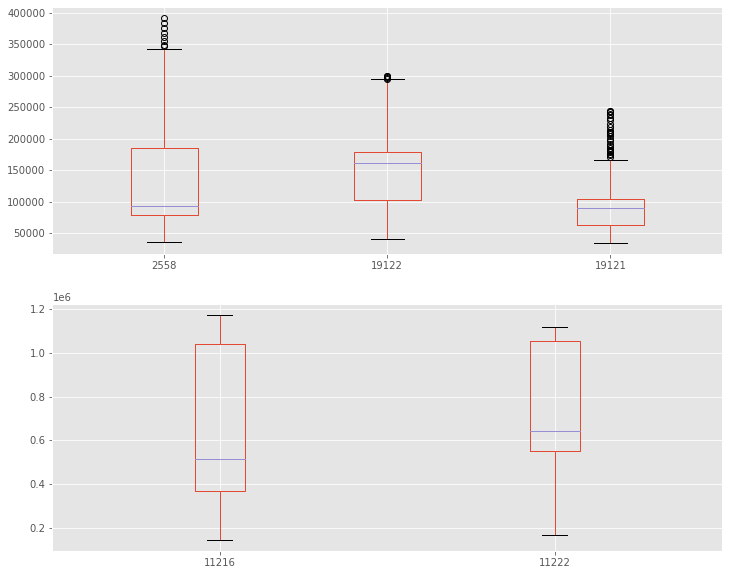

In [97]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
zipcode_df[[2558, 19122, 19121]].boxplot(ax=ax[0])
zipcode_df[[11216, 11222]].boxplot(ax=ax[1]);

Now, let's resample home values by year by taking the average of each year.

In [98]:
zipcode_df = zipcode_df.resample('A').mean()
zipcode_df

Zipcode            10025         10023         10002          11226  \
2000-12-31  3.646009e+05  5.379066e+05  4.389848e+05  275972.833333   
2001-12-31  4.474842e+05  6.368342e+05  4.981035e+05  307207.833333   
2002-12-31  5.003453e+05  7.164314e+05  5.867457e+05  316608.250000   
2003-12-31  5.766275e+05  8.093142e+05  6.739983e+05  357620.250000   
2004-12-31  6.655017e+05  9.159251e+05  7.694815e+05  370821.750000   
2005-12-31  7.981462e+05  1.078528e+06  8.964938e+05  450490.250000   
2006-12-31  8.993602e+05  1.206610e+06  1.019136e+06  529778.250000   
2007-12-31  8.898454e+05  1.207426e+06  1.001938e+06  575287.833333   
2008-12-31  9.139156e+05  1.272393e+06  9.936774e+05  570242.083333   
2009-12-31  7.592758e+05  1.021550e+06  8.512638e+05  508158.333333   
2010-12-31  7.098839e+05  9.388490e+05  7.877474e+05  487055.833333   
2011-12-31  7.404455e+05  9.973832e+05  8.277897e+05  478732.166667   
2012-12-31  7.531898e+05  1.034857e+06  8.437419e+05  493772.333333   
2013-12-31  8.036307e+05  1.103962e+06  9.052522e+05  517564.583333   
2014-12-31  9.132885e+05  1.243271e+06  9.944523e+05  563491.333333   
2015-12-31  9.817538e+05  1.321928e+06  1.074337e+06  640182.500000   
2016-12-31  1.039384e+06  1.392055e+06  1.040234e+06  694898.250000   
2017-12-31  1.039147e+06  1.422695e+06  9.663266e+05  748342.750000   
2018-12-31  1.057255e+06  1.505360e+06  9.109255e+05  776887.333333   
2019-12-31  1.086893e+06  1.419982e+06  1.007627e+06  824127.083333   
2020-12-31  1.051246e+06  1.471571e+06  1.021829e+06  792418.083333   
2021-12-31  1.114519e+06  1.456763e+06  8.776800e+05  802142.625000   

Zipcode             10467         10016         11201          11235  \
2000-12-31  164823.666667  3.289788e+05  3.222060e+05  208098.416667   
2001-12-31  180623.500000  3.953321e+05  4.175659e+05  242964.833333   
2002-12-31  197992.916667  4.446751e+05  5.170409e+05  264738.416667   
2003-12-31  211694.583333  5.106765e+05  6.312908e+05  307811.916667   
2004-12-31  233207.333333  5.910057e+05  7.020879e+05  359351.000000   
2005-12-31  275077.416667  7.183189e+05  8.191126e+05  427209.583333   
2006-12-31  317082.416667  8.170500e+05  9.138893e+05  476112.500000   
2007-12-31  346527.333333  8.049241e+05  9.370448e+05  465784.750000   
2008-12-31  339051.333333  8.996769e+05  9.402719e+05  444148.333333   
2009-12-31  292735.583333  8.447812e+05  9.181426e+05  410038.666667   
2010-12-31  281392.500000  7.975566e+05  8.654409e+05  422418.833333   
2011-12-31  275008.250000  8.411935e+05  8.886562e+05  431056.416667   
2012-12-31  270465.666667  8.458493e+05  9.260222e+05  431186.666667   
2013-12-31  278178.916667  8.908623e+05  1.020022e+06  444496.166667   
2014-12-31  290683.083333  9.914519e+05  1.190800e+06  470702.916667   
2015-12-31  308677.583333  1.065784e+06  1.329834e+06  500886.916667   
2016-12-31  317790.333333  1.104262e+06  1.380020e+06  514640.000000   
2017-12-31  349321.000000  1.108007e+06  1.283377e+06  542356.500000   
2018-12-31  388242.833333  1.096976e+06  1.272612e+06  595656.250000   
2019-12-31  422745.083333  1.065474e+06  1.344990e+06  612674.500000   
2020-12-31  443244.583333  1.011956e+06  1.366793e+06  611137.916667   
2021-12-31  465834.500000  9.818735e+05  1.274202e+06  629691.500000   

Zipcode             11375          10029         10009         10011  \
2000-12-31  344861.333333  265611.090909  4.043634e+05  7.548758e+05   
2001-12-31  388981.666667  316709.916667  4.752948e+05  8.902272e+05   
2002-12-31  409970.666667  344068.000000  5.968178e+05  1.023533e+06   
2003-12-31  431830.083333  397041.833333  6.719491e+05  1.136206e+06   
2004-12-31  457764.666667  480039.833333  7.600085e+05  1.245471e+06   
2005-12-31  539170.000000  583569.000000  9.146243e+05  1.509691e+06   
2006-12-31  605658.416667  680099.416667  1.010553e+06  1.685432e+06   
2007-12-31  591835.083333  686478.916667  9.541199e+05  1.653163e+06   
2008-12-31  575741.500000  704722.750000  9.686942e+05  1.643

Let's visualize home values for 20 zipcodes.

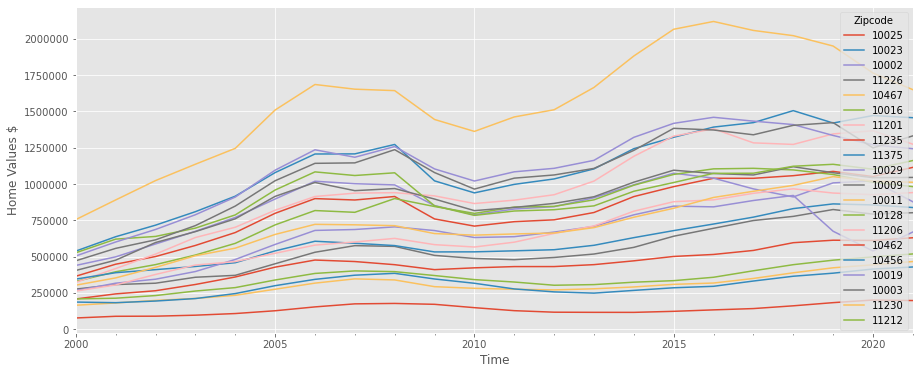

In [99]:
fig, ax = plt.subplots()
zipcode_df.iloc[:, :20].plot(ax=ax)
ax.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.ylabel('Home Values $')
plt.xlabel('Time');

Now, let's transpose the dataframe back.

In [100]:
zipcode_df = zipcode_df.T
zipcode_df.head()

2000-12-31     2001-12-31     2002-12-31     2003-12-31  \
Zipcode                                                               
10025    364600.916667  447484.250000  500345.333333  576627.500000   
10023    537906.583333  636834.166667  716431.416667  809314.166667   
10002    438984.750000  498103.500000  586745.666667  673998.333333   
11226    275972.833333  307207.833333  316608.250000  357620.250000   
10467    164823.666667  180623.500000  197992.916667  211694.583333   

            2004-12-31    2005-12-31    2006-12-31    2007-12-31  \
Zipcode                                                            
10025    665501.666667  7.981462e+05  8.993602e+05  8.898454e+05   
10023    915925.083333  1.078528e+06  1.206610e+06  1.207426e+06   
10002    769481.500000  8.964938e+05  1.019136e+06  1.001938e+06   
11226    370821.750000  4.504902e+05  5.297782e+05  5.752878e+05   
10467    233207.333333  2.750774e+05  3.170824e+05  3.465273e+05   

           2008-12-31    2009-12-31     2010-12-31     2011-12-31  \
Zipcode                                                             
10025    9.139156e+05  7.592758e+05  709883.916667  740445.500000   
10023    1.272393e+06  1.021550e+06  938849.000000  997383.166667   
10002    9.936774e+05  8.512638e+05  787747.416667  827789.666667   
11226    5.702421e+05  5.081583e+05  487055.833333  478732.166667   
10467    3.390513e+05  2.927356e+05  281392.500000  275008.250000   

           2012-12-31    2013-12-31    2014-12-31    2015-12-31    2016-12-31  \
Zipcode                                                                         
10025    7.531898e+05  8.036307e+05  9.132885e+05  9.817538e+05  1.039384e+06   
10023    1.034857e+06  1.103962e+06  1.243271e+06  1.321928e+06  1.392055e+06   
10002    8.437419e+05  9.052522e+05  9.944523e+05  1.074337e+06  1.040234e+06   
11226    4.937723e+05  5.175646e+05  5.634913e+05  6.401825e+05  6.948982e+05   
10467    2.704657e+05  2.781789e+05  2.906831e+05  3.086776e+05  3.177903e+05   

           2017-12-31    2018-12-31    2019-12-31    2020-12-31   2021-12-31  
Zipcode                                                                       
10025    1.039147e+06  1.057255e+06  1.086893e+06  1.051246e+06  1114518.875  
10023    1.422695e+06  1.505360e+06  1.419982e+06  1.471571e+06  1456762.750  
10002    9.663266e+05  9.109255e+05  1.007627e+06  1.021829e+06   877680.000  
11226    7.483428e+05  7.768873e+05  8.241271e+05  7.924181e+05   802142.625  
10467    3.493210e+05  3.882428e+05  4.227451e+05  4.432446e+05   465834.500

To figure out which zipcodes are the best to invest in, we are going to calculate the return rate per year. 

In [101]:
zipcode_df['return_rate'] = ((zipcode_df['2021-12-31'] - zipcode_df['2000-12-31']) / zipcode_df['2000-12-31'])*100
zipcode_df['return_rate_per_year'] = zipcode_df['return_rate']/21
zipcode_df.head()

2000-12-31 00:00:00  2001-12-31 00:00:00  2002-12-31 00:00:00  \
Zipcode                                                                  
10025          364600.916667        447484.250000        500345.333333   
10023          537906.583333        636834.166667        716431.416667   
10002          438984.750000        498103.500000        586745.666667   
11226          275972.833333        307207.833333        316608.250000   
10467          164823.666667        180623.500000        197992.916667   

         2003-12-31 00:00:00  2004-12-31 00:00:00  2005-12-31 00:00:00  \
Zipcode                                                                  
10025          576627.500000        665501.666667         7.981462e+05   
10023          809314.166667        915925.083333         1.078528e+06   
10002          673998.333333        769481.500000         8.964938e+05   
11226          357620.250000        370821.750000         4.504902e+05   
10467          211694.583333        233207.333333         2.750774e+05   

         2006-12-31 00:00:00  2007-12-31 00:00:00  2008-12-31 00:00:00  \
Zipcode                                                                  
10025           8.993602e+05         8.898454e+05         9.139156e+05   
10023           1.206610e+06         1.207426e+06         1.272393e+06   
10002           1.019136e+06         1.001938e+06         9.936774e+05   
11226           5.297782e+05         5.752878e+05         5.702421e+05   
10467           3.170824e+05         3.465273e+05         3.390513e+05   

         2009-12-31 00:00:00  2010-12-31 00:00:00  2011-12-31 00:00:00  \
Zipcode                                                                  
10025           7.592758e+05        709883.916667        740445.500000   
10023           1.021550e+06        938849.000000        997383.166667   
10002           8.512638e+05        787747.416667        827789.666667   
11226           5.081583e+05        487055.833333        478732.166667   
10467           2.927356e+05        281392.500000        275008.250000   

         2012-12-31 00:00:00  2013-12-31 00:00:00  2014-12-31 00:00:00  \
Zipcode                                                                  
10025           7.531898e+05         8.036307e+05         9.132885e+05   
10023           1.034857e+06         1.103962e+06         1.243271e+06   
10002           8.437419e+05         9.052522e+05         9.944523e+05   
11226           4.937723e+05         5.175646e+05         5.634913e+05   
10467           2.704657e+05         2.781789e+05         2.906831e+05   

         2015-12-31 00:00:00  2016-12-31 00:00:00  2017-12-31 00:00:00  \
Zipcode                                                                  
10025           9.817538e+05         1.039384e+06         1.039147e+06   
10023           1.321928e+06         1.392055e+06         1.422695e+06   
10002           1.074337e+06         1.040234e+06         9.663266e+05   
11226           6.401825e+05         6.948982e+05         7.483428e+05   
10467           3.086776e+05         3.177903e+05         3.493210e+05   

         2018-12-31 00:00:00  2019-12-31 00:00:00  2020-12-31 00:00:00  \
Zipcode                                                                  
10025           1.057255e+06         1.086893e+06         1.051246e+06   
10023           1.505360e+06         1.419982e+06         1.471571e+06   
10002           9.109255e+05         1.007627e+06         1.021829e+06   
11226           7.768873e+05         8.241271e+05         7.924181e+05   
10467           3.882428e+05         4.227451e+05         4.432446e+05   

         2021-12-31 00:00:00  return_rate  return_rate_per_year  
Zipcode                                                          
10025            1114518.875   205.681863              9.794374  
10023            1456762.750   170.820770              8.134322  
10002             877680.000    99.934052              4.758764  
11226             802142.625   190.659996     

With the return rate per year, we are going to pick the top 5 highest return rate.

In [102]:
zipcode_df.sort_values(by='return_rate_per_year', ascending=False).head(5).index

Int64Index([2558, 11216, 19122, 19121, 11222], dtype='int64', name='Zipcode')

We found that zipcodes 2558, 11216, 19122, 19121, 11222 are the best areas to invest in.

Now, let's create a new dataframe with just the 5 zipcodes.

In [103]:
top_five_df = df[df['Zipcode'].isin([2558, 11216, 19122, 19121, 11222])]
top_five_df

RegionID  SizeRank  Zipcode RegionType StateName State          City  \
513       62027       516    11216        Zip        NY    NY      New York   
1181      62033      1187    11222        Zip        NY    NY      New York   
1561      65788      1572    19121        Zip        PA    PA  Philadelphia   
5329      65789      5379    19122        Zip        PA    PA  Philadelphia   
16413     58807     16737     2558        Zip        MA    MA       Wareham   

                                Metro           CountyName  2000-01-31  \
513       New York-Newark-Jersey City         Kings County    146780.0   
1181      New York-Newark-Jersey City         Kings County    166164.0   
1561   Philadelphia-Camden-Wilmington  Philadelphia County     35211.0   
5329   Philadelphia-Camden-Wilmington  Philadelphia County     40085.0   
16413         Boston-Cambridge-Newton      Plymouth County     36773.0   

       2000-02-29  2000-03-31  2000-04-30  2000-05-31  2000-06-30  2000-07-31  \
513      147714.0    149286.0    152704.0    155479.0    157950.0    159636.0   
1181     167963.0    166884.0    167666.0    167825.0    172111.0    177306.0   
1561      34351.0     34498.0     34373.0     35114.0     35255.0     35125.0   
5329      40648.0     41501.0     43180.0     44963.0     45552.0     45143.0   
16413     36071.0     36554.0     36148.0     36472.0     35684.0     36009.0   

       2000-08-31  2000-09-30  2000-10-31  2000-11-30  2000-12-31  2001-01-31  \
513      161633.0    163728.0    166215.0    169095.0    171533.0    174179.0   
1181     182470.0    186711.0    190934.0    195742.0    200303.0    204407.0   
1561      35821.0     37193.0     38286.0     39067.0     39236.0     39887.0   
5329      43662.0     42690.0     42431.0     43118.0     43906.0     45162.0   
16413     36361.0     37446.0     38352.0     38789.0     38914.0     39113.0   

       2001-02-28  2001-03-31  2001-04-30  2001-05-31  2001-06-30  2001-07-31  \
513      176378.0    179995.0    182328.0    185189.0    186919.0    188863.0   
1181     206336.0    211670.0    217002.0    224291.0    227723.0    226873.0   
1561      39719.0     39528.0     40303.0     41228.0     42125.0     42235.0   
5329      46588.0     47179.0     47127.0     46865.0     47969.0     48795.0   
16413     40207.0     41983.0     43686.0     45211.0     46299.0     47293.0   

       2001-08-31  2001-09-30  2001-10-31  2001-11-30  2001-12-31  2002-01-31  \
513      190017.0    190920.0    191661.0    192607.0    193402.0    196350.0   
1181     226089.0    225971.0    229188.0    233636.0    238919.0    248404.0   
1561      42572.0     42457.0     42991.0     42760.0     42340.0     41563.0   
5329      49715.0     50746.0     52505.0     54271.0     54168.0     53877.0   
16413     48740.0     51070.0     52656.0     53296.0     52775.0     52842.0   

       2002-02-28  2002-03-31  2002-04-30  2002-05-31  2002-06-30  2002-07-31  \
513      202319.0    209386.0    214557.0    216980.0    218140.0    219961.0   
1181     263129.0    279783.0    291884.0    297051.0    299606.0    302672.0   
1561      41242.0     41957.0     42249.0     42234.0     42647.0     42531.0   
5329      53260.0     54008.0     55384.0     57565.0     60367.0     62563.0   
16413     52963.0     53097.0     53682.0     54870.0     56676.0     58101.0   

       2002-08-31  2002-09-30  2002-10-31  2002-11-30  2002-12-31  2003-01-31  \
513      225423.0    231151.0    236091.0    237881.0    239699.0    241739.0   
1181     309655.0    315991.0    322663.0    326257.0    329570.0    332251.0   
1561      42657.0     42315.0     43533.0     44857.0     46289.0     46328.0   
5329      63012.0     64212.0     64908.0     66469.0     66678.0     67413.0   
16413     60027.0     62430.0     65393.0     67859.0     69474.0     70639.0   

       2003-02-28  2003-03-31  2003-04-30  2003-05-31  2003-06-30  2003-07-31  \
513      247797.0    255283.0    263500.0    269034.0    274149.0    278532.0   
118

With the melt function, we are going to create 5 dataframs with just the home values.

In [104]:
df_2558 = melt_data(top_five_df[top_five_df['Zipcode'] == 2558])
df_11216 = melt_data(top_five_df[top_five_df['Zipcode'] == 11216])
df_19122 = melt_data(top_five_df[top_five_df['Zipcode'] == 19122])
df_19121 = melt_data(top_five_df[top_five_df['Zipcode'] == 19121])
df_11222 = melt_data(top_five_df[top_five_df['Zipcode'] == 11222])

Let's try to visualize our melted dataframe

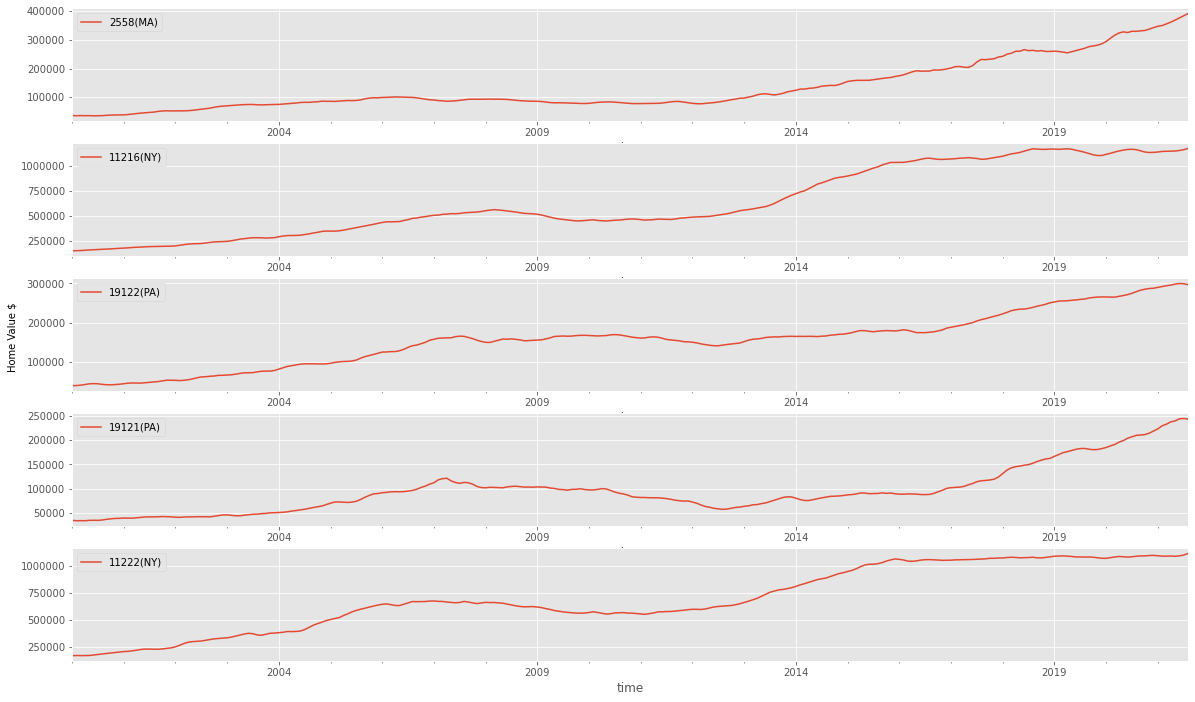

In [128]:
fig, ax = plt.subplots(5,1,figsize=(20,12))

df_2558.plot(ax=ax[0])
ax[0].legend(['2558(MA)'])
ax[0].ticklabel_format(useOffset=False, style='plain', axis='y')

df_11216.plot(ax=ax[1])
ax[1].legend(['11216(NY)'])
ax[1].ticklabel_format(useOffset=False, style='plain', axis='y')

df_19122.plot(ax=ax[2])
ax[2].legend(['19122(PA)'])
ax[2].ticklabel_format(useOffset=False, style='plain', axis='y')

df_19121.plot(ax=ax[3])
ax[3].legend(['19121(PA)'])
ax[3].ticklabel_format(useOffset=False, style='plain', axis='y')

df_11222.plot(ax=ax[4])
ax[4].legend(['11222(NY)'])
ax[4].ticklabel_format(useOffset=False, style='plain', axis='y')

fig.text(0.08, 0.5, 'Home Value $', va='center', rotation='vertical');

For each zipcode, we are going to predict future home values.

## ZipCode 2558

First, we are going to predict home values for zipcode 2558.

### Baseline Model

We are going to create a simple baseline model by taking one shift before the original data.

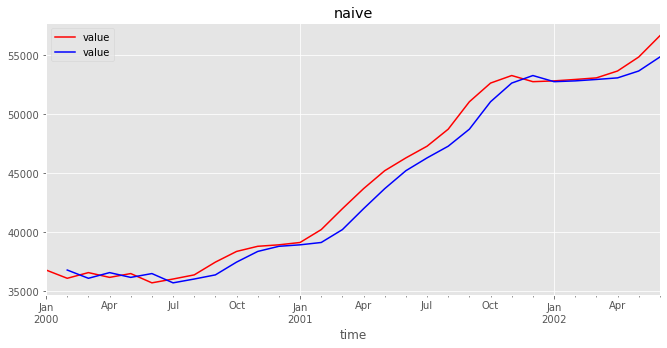

In [106]:
naive = df_2558.shift(1)

fig, ax = plt.subplots(figsize=(11, 5))

df_2558[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

In [107]:
dftest = adfuller(naive.dropna())
print ('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used',
                            'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   3.036318
p-value                          1.000000
#Lags Used                      15.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


From the adfuller test, we can see that our p-value > 0.05. So, we reject our null hypothesis and the model is non-stationary. 

### Differencing

We want to try to make our models stationary. So, we are going to try to reduce trends/seasonalities fromthe data.

In [108]:
diff = df_2558.diff().dropna()

dftest = adfuller(diff)
print ('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used',
                            'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -0.452923
p-value                          0.900880
#Lags Used                      16.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


First differencing did not make the model be stationary.

Let's try differencing twice.

In [109]:
diff = df_2558.diff().diff().dropna()

dftest = adfuller(diff)
print ('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used',
                            'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.140500e+00
p-value                        7.992902e-08
#Lags Used                     1.600000e+01
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


The model is statioanry now since p-value < 0.05.

Let's look at the autocorrelation for this model.

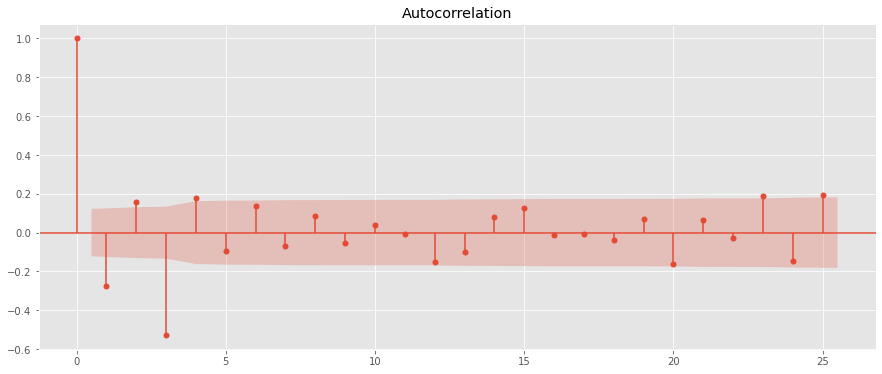

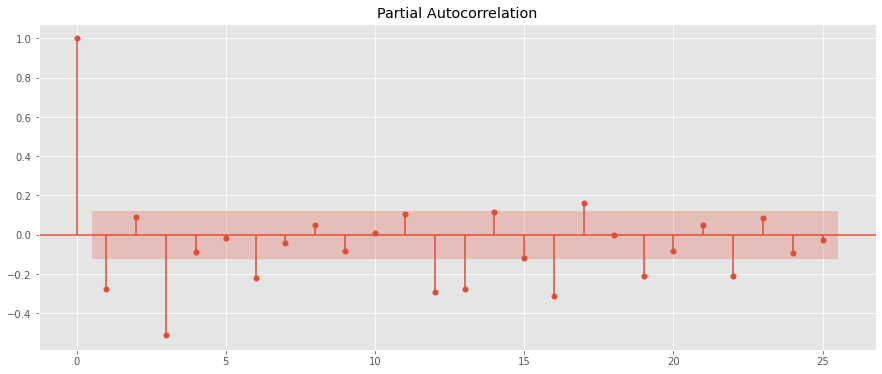

In [110]:
# Autocorrelation Plot
plot_acf(df_2558.diff().diff().dropna());

# Partial Autocorrelation Plot
plot_pacf(df_2558.diff().diff().dropna());

### SARIMAX Model

We are going to use SARIMAX model to model our data.

To get the best hyperparameters for our model, we created a combination of orders and seasonal orders in the range of 0-2, inclusive.

In [26]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [27]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(df_2558,
                         order=comb,
                         seasonal_order=combs,
                         enforce_stationarity=False,
                         enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =6945.726919411753
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =25586.073998553886
ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =9815.083876928566
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5680.111023116086
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5361.616047414196
ARIMA (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =5083.3586541848435
ARIMA (0, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =5286.82737379625
ARIMA (0, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated =4964.659175104311
ARIMA (0, 0, 0) x (0, 2, 2, 12)12 : AIC Calculated =4693.40886945075
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5436.996910992569
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =14645.654208778637
ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =5141.65514325268
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5291.414035464193
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =5210.303910663821
ARIMA (0, 0, 0) x (1

ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =4511.135390231808
ARIMA (0, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =4281.939052619437
ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4372.8780083943875
ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =4293.8224975723515
ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =4065.591592608544
ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =4316.129903571211
ARIMA (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =4137.019856773436
ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3894.06876669961
ARIMA (0, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =4334.515087669653
ARIMA (0, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =4327.882669264403
ARIMA (0, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =4290.678710667911
ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =4139.86142431042
ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =4109.155906401747
ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =4067.109168574766
ARIMA (0, 1, 1) x (2

ARIMA (0, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =4228.159298649193
ARIMA (0, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =4178.711450241708
ARIMA (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =4094.5776687928605
ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =4064.6468117207696
ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3997.4142460455723
ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =4012.376249212193
ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3915.6651485868488
ARIMA (0, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3862.899765872011
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =4727.184006308147
ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =4512.483546325615
ARIMA (1, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =4367.243932455058
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =4730.253510694957
ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =4420.559758935084
ARIMA (1, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =4141.938549815835
ARIMA (1, 0, 0) 

ARIMA (1, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =4211.76698694305
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4601.483504648645
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =4272.67146438849
ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =4024.9510794443495
ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4637.528269954357
ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =4277.906897167558
ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3888.7323866409097
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =4433.614670305689
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =4417.336658708586
ARIMA (1, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =4213.564639564916
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4330.3598964088515
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =4265.435510405325
ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =4019.583499768569
ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =4285.56656447185
ARIMA (1, 1, 1) x (1

ARIMA (1, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =4158.143657208509
ARIMA (1, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =4313.116794415677
ARIMA (1, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =4220.3185468239735
ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3979.8706204767773
ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =4333.398118970107
ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =4253.011862735574
ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =4014.03559886063
ARIMA (1, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =4195.017918871637
ARIMA (1, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =4195.855833049733
ARIMA (1, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =4158.250622330881
ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =4058.723208493161
ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =4032.517394458919
ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3996.8279236509015
ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3975.4251743613913
ARIMA (1, 2, 2) x

ARIMA (2, 1, 0) x (2, 0, 2, 12)12 : AIC Calculated =4213.347120029161
ARIMA (2, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =4051.7157315624945
ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =4032.871416191643
ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =4017.957629168445
ARIMA (2, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3964.41583206416
ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3869.357215754029
ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3870.468218088844
ARIMA (2, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =4614.245709538329
ARIMA (2, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =4411.381817608075
ARIMA (2, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =4188.539928769296
ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4596.3519181959055
ARIMA (2, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =4291.538374841119
ARIMA (2, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =4056.55724386451
ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4618.2110740090975
ARIMA (2, 1, 1) x (

ARIMA (2, 2, 2) x (0, 0, 2, 12)12 : AIC Calculated =4140.717765999255
ARIMA (2, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =4568.455435760807
ARIMA (2, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =4212.460140403449
ARIMA (2, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3964.087158854865
ARIMA (2, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =4610.212443025661
ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =4189.460598275912
ARIMA (2, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3847.9182313504566
ARIMA (2, 2, 2) x (1, 0, 0, 12)12 : AIC Calculated =4362.34171201511
ARIMA (2, 2, 2) x (1, 0, 1, 12)12 : AIC Calculated =4346.131135653586
ARIMA (2, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =4142.379760480484
ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =4272.873613612326
ARIMA (2, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =4202.143122237814
ARIMA (2, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3963.963002904722
ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =4308.169865994105
ARIMA (2, 2, 2) x (1

In [28]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 2)
pdqs    (0, 2, 2, 12)
aic       3811.805781
Name: 386, dtype: object

From the combination, our SARIMAX model with order=(1, 1, 2) and seasonal_order=(0, 2, 2, 12) got the lowest aic score, which was 3811.805781.

Now, we can use those hyperparameters for our final model to predict future home values.

In [111]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_2558, 
                                        order=(1, 1, 2), 
                                        seasonal_order=(0, 2, 2, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2071      0.059     -3.506      0.000      -0.323      -0.091
ma.L1          0.8823      0.029     30.300      0.000       0.825       0.939
ma.L2          0.9032      0.028     32.288      0.000       0.848       0.958
ma.S.L12      -1.6279      0.046    -35.636      0.000      -1.717      -1.538
ma.S.L24       0.6678      0.044     15.164      0.000       0.581       0.754
sigma2       3.87e+06   9.05e-09   4.28e+14      0.000    3.87e+06    3.87e+06


From the summary table, we can see that all of the weight has a p-value lower or close to 0.05.

Next, we ran model diagnostics to ensure that none of the assumptions made by the model have been violated.

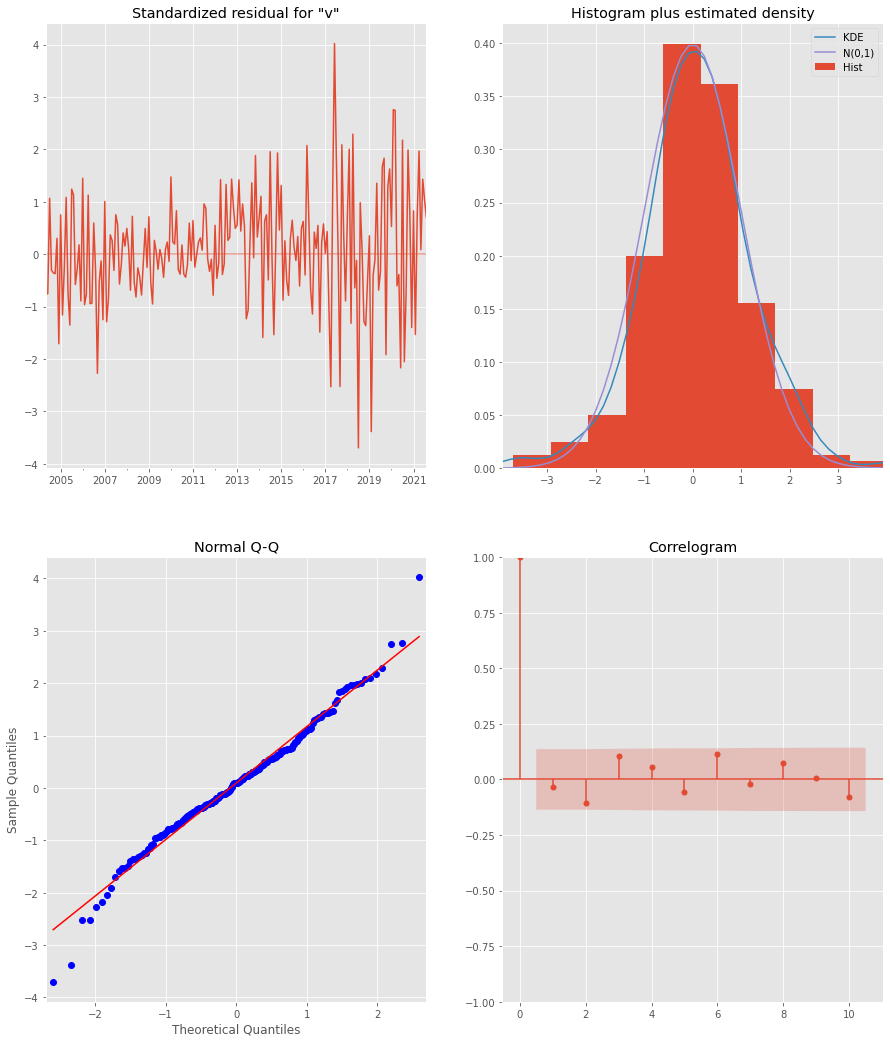

In [112]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

The first plot shows that the residuals are mostly normally distributed. The top right plot shows that the data seems normally distributed. The bottom left plot shows that the residuals follow the linear trend from a standard normal distribution. The bottom right plot shows that the autocorrelation.

### Validating the Model

We will now validate the model by comparing predicted values to real values.

We will validate last two years, starting from 2019-01-31.

In [113]:
# Get predictions starting from 01-31-2019 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2019-01-31'), dynamic=False)
pred_conf = pred.conf_int()

With the predicted values, we can plot the real and forecasted home values.

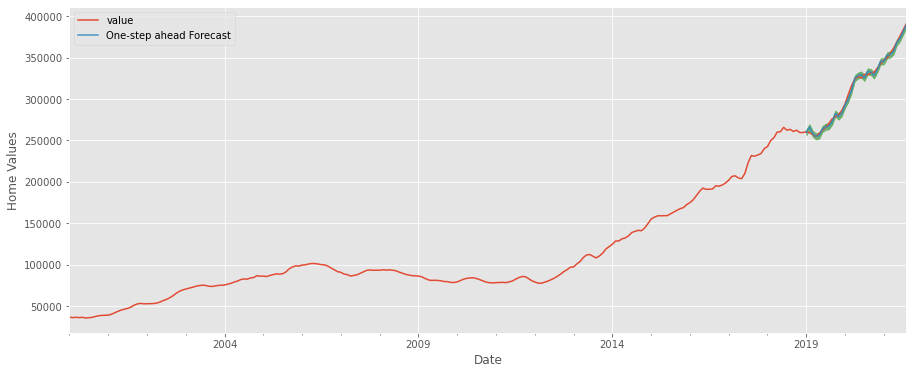

In [114]:
# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = df_2558.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Values')
plt.legend()

plt.show();

The forecasts align with the true values as seen above, with overall increase trend. 

We will check for the accuracy of our forecasts using RMSE (Root Mean Squared Error).

In [115]:
# Get the real and predicted values
value_forecasted = pred.predicted_mean
value_truth = df_2558['value']['2019-01-31':]

# Compute the root mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 3033.68


### Dynamic Forecasting

Let's try to achieve a deep insight by using dynamic forecasts.

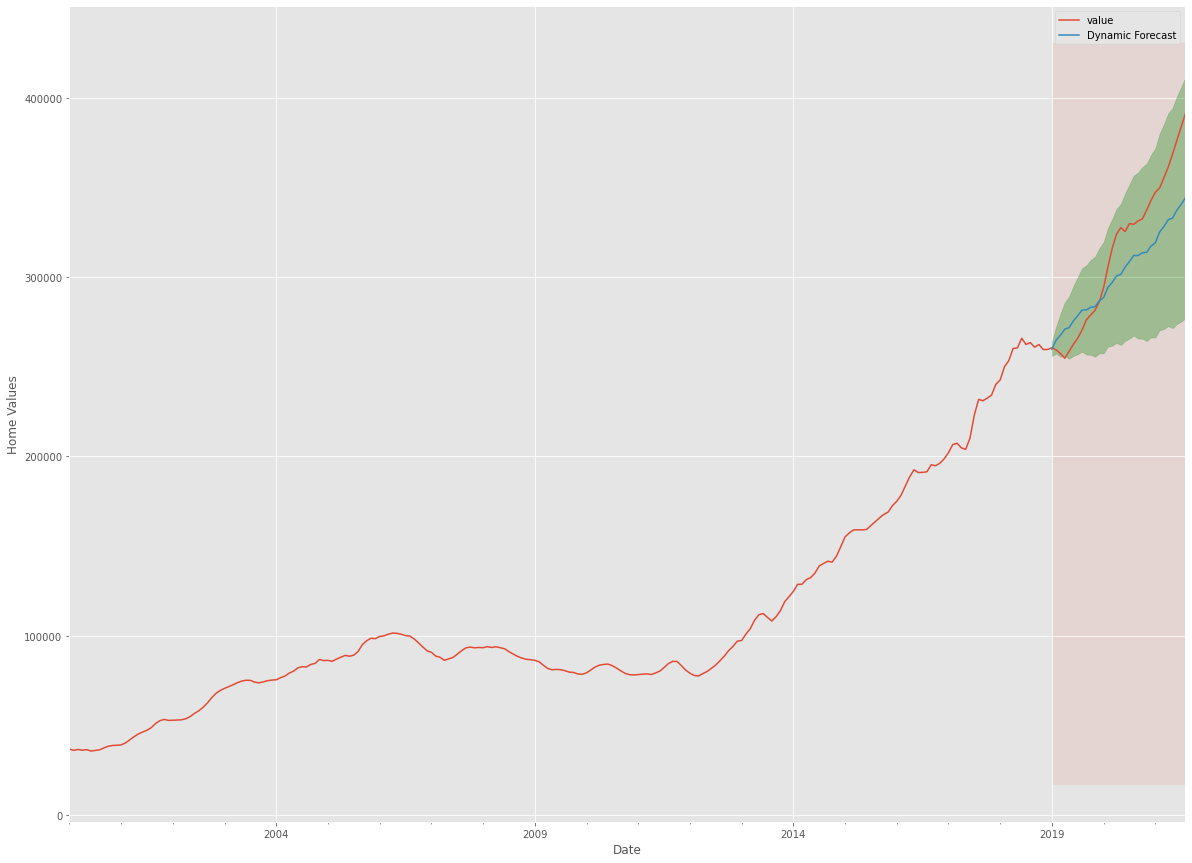

In [116]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2019-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot the dynamic forecast with confidence intervals.
ax = df_2558.plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2019-01-31'), value_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Home Values')

plt.legend()
plt.show();

In [117]:
# Extract the predicted and true values of our time series
value_forecasted = pred_dynamic.predicted_mean
value_truth = df_2558['value']['2019-01-31':]

# Compute the mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 22190.32


The RMSE score is lower here than what we got before.

### Producing and Visualizing Forecasts

Now, we will forecast future home values

In [118]:
# Get forecast 100 steps ahead in future
prediction = output.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

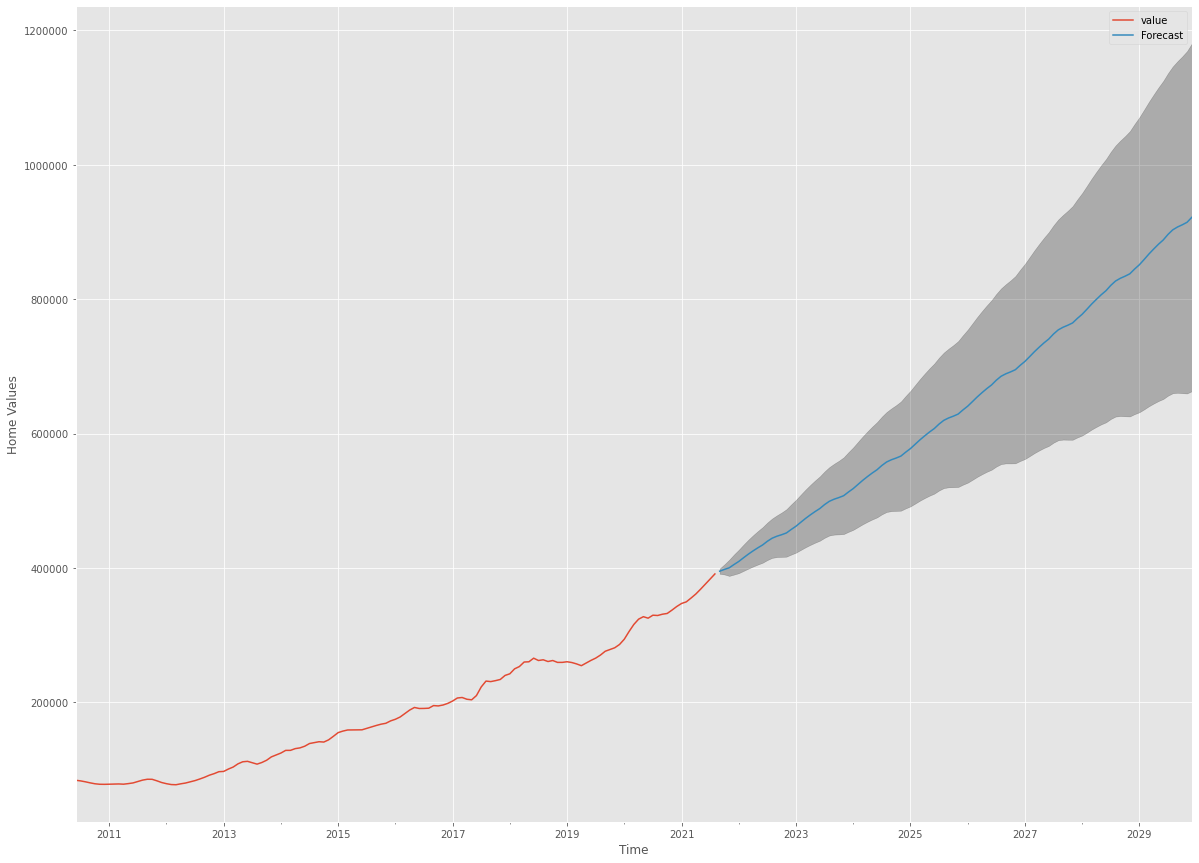

In [121]:
# Plot future predictions with confidence intervals
ax = df_2558.iloc[125:].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Time')
ax.set_ylabel('Home Values')
ax.ticklabel_format(useOffset=False, style='plain', axis='y')

plt.legend()
plt.show()

Both the forecasts and associated confidence interval that we have generated can now be used to further understand the dataset for zipcode 2558 and foresee what to expect. We get less confident as we go more into the future.